# Approximate q-learning

In this notebook you will teach a __pytorch__ neural network to do Q-learning.

In [5]:
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [6]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/home/denis/anaconda3/envs/tourch_gym/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


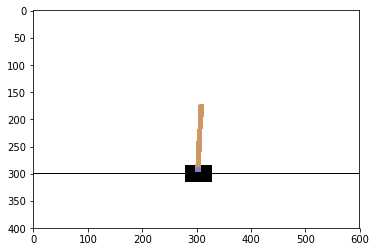

In [7]:
env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))
env.close()

# Approximate Q-learning: building the network

To train a neural network policy one must have a neural network policy. Let's build it.


Since we're working with a pre-extracted features (cart positions, angles and velocities), we don't need a complicated network yet. In fact, let's build something like this for starters:

![img](https://s14.postimg.org/uzay2q5rl/qlearning_scheme.png)

For your first run, please only use linear layers (nn.Linear) and activations. Stuff like batch normalization or dropout may ruin everything if used haphazardly. 

Also please avoid using nonlinearities like sigmoid & tanh: agent's observations are not normalized so sigmoids may become saturated from init.

Ideally you should start small with maybe 1-2 hidden layers with < 200 neurons and then increase network size if agent doesn't beat the target score.

In [8]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [9]:
network = nn.Sequential(
    nn.Linear(state_dim[0],128),
    nn.ReLU(),
    nn.Linear(128,n_actions)
)

#network.add_module(nn.)

#<YOUR CODE: stack layers!!!1 >
    
# hint: use state_dim[0] as input size    

In [10]:
env.reset()

array([-0.00763867,  0.00382988, -0.00076763,  0.00616991])

In [11]:
l = network.forward(Variable(torch.FloatTensor([env.reset()])))#.data.numpy()

In [12]:
l, l.size()

(tensor([[-0.0594, -0.1501]], grad_fn=<AddmmBackward>), torch.Size([1, 2]))

In [13]:
def get_action(state, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """
    state = Variable(torch.FloatTensor(state[None]))
    q_values = network(state).data.numpy()
    
    if np.random.uniform(0,1) < epsilon:
        return int(np.random.choice(n_actions))
    else:
    ###YOUR CODE
        
    
        return int(np.argmax(q_values[0]))


In [10]:
s = env.reset()
assert tuple(network(Variable(torch.FloatTensor([s]*3))).size()) == (3, n_actions), "please make sure your model maps state s -> [Q(s,a0), ..., Q(s, a_last)]"
assert isinstance(list(network.modules())[-1], nn.Linear), "please make sure you predict q-values without nonlinearity (ignore if you know what you're doing)"
assert isinstance(get_action(s), int), "get_action(s) must return int, not %s. try int(action)" % (type(get_action(s)))

# test epsilon-greedy exploration
for eps in [0., 0.1, 0.5, 1.0]:
    state_frequencies = np.bincount([get_action(s, epsilon=eps) for i in range(10000)], minlength=n_actions)
    best_action = state_frequencies.argmax()
    assert abs(state_frequencies[best_action] - 10000 * (1 - eps + eps / n_actions)) < 200
    for other_action in range(n_actions):
        if other_action != best_action:
            assert abs(state_frequencies[other_action] - 10000 * (eps / n_actions)) < 200
    print('e=%.1f tests passed'%eps)

e=0.0 tests passed
e=0.1 tests passed
e=0.5 tests passed
e=1.0 tests passed


In [36]:
np.bincount(np.array([1,2,3,4,3,10]))

array([0, 1, 1, 2, 1, 0, 0, 0, 0, 0, 1])

### Q-learning via gradient descent

We shall now train our agent's Q-function by minimizing the TD loss:
$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2 $$


Where
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

The tricky part is with  $Q_{-}(s',a')$. From an engineering standpoint, it's the same as $Q_{\theta}$ - the output of your neural network policy. However, when doing gradient descent, __we won't propagate gradients through it__ to make training more stable (see lectures).

To do so, we shall use `x.detach()` function which basically says "consider this thing constant when doingbackprop".

In [11]:
def to_one_hot(y, n_dims=None):
    """ helper: take an integer vector (tensor of variable) and convert it to 1-hot matrix. """
    y_tensor = y.data if isinstance(y, Variable) else y
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    return Variable(y_one_hot) if isinstance(y, Variable) else y_one_hot

def where(cond, x_1, x_2):
    """ helper: like np.where but in pytorch. """
    return (cond * x_1) + ((1-cond) * x_2)

In [12]:
k = torch.FloatTensor([1,2,6])
to_one_hot(k, 7), torch.max(k)

(tensor([[0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1.]]), tensor(6.))

In [2]:
def compute_td_loss(states, actions, rewards, next_states, is_done, gamma = 0.99, check_shapes = False):
    """ Compute td loss using torch operations only. Use the formula above. """
    states = Variable(torch.FloatTensor(states))    # shape: [batch_size, state_size]
    
    actions = Variable(torch.IntTensor(actions))    # shape: [batch_size]
    rewards = Variable(torch.FloatTensor(rewards))  # shape: [batch_size]
    next_states = Variable(torch.FloatTensor(next_states)) # shape: [batch_size, state_size]
    is_done = Variable(torch.FloatTensor(is_done))  # shape: [batch_size]
    
    #get q-values for all actions in current states
    predicted_qvalues = network(states)
    print(predicted_qvalues, to_one_hot(actions, n_actions), torch.sum(predicted_qvalues * to_one_hot(actions, n_actions), dim=1))#, predicted_qvalues.size())
    #select q-values for chosen actions
    predicted_qvalues_for_actions = torch.sum(predicted_qvalues * to_one_hot(actions, n_actions), dim=1)
    
    # compute q-values for all actions in next states
    predicted_next_qvalues = network(next_states)

    # compute V*(next_states) using predicted next q-values
    next_state_values = torch.max(predicted_next_qvalues, dim=1)[0]
    assert isinstance(next_state_values.data, torch.FloatTensor)

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    target_qvalues_for_actions = rewards + gamma * next_state_values

    # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    target_qvalues_for_actions = where(is_done, rewards, target_qvalues_for_actions)
    
    #mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions - target_qvalues_for_actions.detach_()) ** 2 )
    #print(predicted_qvalues_for_actions.size(), target_qvalues_for_actions.detach_().size(), loss.size())
    
    if check_shapes:
        assert predicted_next_qvalues.data.dim() == 2, "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim() == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim() == 1, "there's something wrong with target q-values, they must be a vector"
    
    return loss[None]

    

In [3]:
a

NameError: name 'a' is not defined

In [4]:
# sanity checks
s = env.reset()
a = env.action_space.sample()
next_s, r, done, _ = env.step(a)
#print(next_s, r, done, _)
loss = compute_td_loss([s],[a],[r],[next_s],[done], check_shapes=True)
#print(loss.size())
loss.backward()

assert isinstance(Variable(loss), Variable) and tuple(loss.data.size()) == (1,), "you must return scalar loss - mean over batch"
assert np.any(next(network.parameters()).grad.data.numpy() != 0), "loss must be differentiable w.r.t. network weights"

NameError: name 'env' is not defined

In [1]:
# Baga in pytorch version!!

g = Variable(torch.FloatTensor([2,3]))
torch.mean(g + g).size(), torch.mean(g + g).shape, torch.mean(g + g)

NameError: name 'Variable' is not defined

### Playing the game

In [31]:
#opt = torch.optim.SGD(network.parameters(), lr=0.05, momentum=0.9)
opt = torch.optim.SGD(network.parameters(), lr=1e-4)
epsilon = 0.05

In [32]:
def generate_session(t_max=1000, epsilon=0, train=False):
    """play env with approximate q-learning agent and train it at the same time"""
    total_reward = 0
    s = env.reset()
    
    for t in range(t_max):
        a = get_action(s, epsilon=epsilon)       
        next_s, r, done, _ = env.step(a)
        
        if train:
            opt.zero_grad()
            compute_td_loss([s], [a], [r], [next_s], [done]).backward()
            opt.step()
            
        total_reward += r
        s = next_s
        if done: break
            
    return total_reward

In [33]:
for i in range(1000):
    session_rewards = [generate_session(epsilon=epsilon, train=True) for _ in range(100)]
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), epsilon))
    
    epsilon *= 0.99
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"
    
    if np.mean(session_rewards) > 300:
        print ("You Win!")
        break


epoch #0	mean reward = 9.560	epsilon = 0.050
epoch #1	mean reward = 9.610	epsilon = 0.050
epoch #2	mean reward = 9.600	epsilon = 0.049
epoch #3	mean reward = 9.650	epsilon = 0.049
epoch #4	mean reward = 9.730	epsilon = 0.048
epoch #5	mean reward = 9.540	epsilon = 0.048
epoch #6	mean reward = 9.590	epsilon = 0.047
epoch #7	mean reward = 9.670	epsilon = 0.047
epoch #8	mean reward = 9.590	epsilon = 0.046
epoch #9	mean reward = 9.480	epsilon = 0.046
epoch #10	mean reward = 9.710	epsilon = 0.045
epoch #11	mean reward = 9.730	epsilon = 0.045
epoch #12	mean reward = 9.530	epsilon = 0.044
epoch #13	mean reward = 9.720	epsilon = 0.044
epoch #14	mean reward = 10.010	epsilon = 0.043
epoch #15	mean reward = 10.620	epsilon = 0.043
epoch #16	mean reward = 11.160	epsilon = 0.043
epoch #17	mean reward = 11.490	epsilon = 0.042
epoch #18	mean reward = 12.100	epsilon = 0.042
epoch #19	mean reward = 12.440	epsilon = 0.041
epoch #20	mean reward = 12.250	epsilon = 0.041
epoch #21	mean reward = 12.150	epsilo

### How to interpret results


Welcome to the f.. world of deep f...n reinforcement learning. Don't expect agent's reward to smoothly go up. Hope for it to go increase eventually. If it deems you worthy.

Seriously though,
* __ mean reward__ is the average reward per game. For a correct implementation it may stay low for some 10 epochs, then start growing while oscilating insanely and converges by ~50-100 steps depending on the network architecture. 
* If it never reaches target score by the end of for loop, try increasing the number of hidden neurons or look at the epsilon.
* __ epsilon__ - agent's willingness to explore. If you see that agent's already at < 0.01 epsilon before it's is at least 200, just reset it back to 0.1 - 0.5.

### Record videos

As usual, we now use `gym.wrappers.Monitor` to record a video of our agent playing the game. Unlike our previous attempts with state binarization, this time we expect our agent to act ~~(or fail)~~ more smoothly since there's no more binarization error at play.

As you already did with tabular q-learning, we set epsilon=0 for final evaluation to prevent agent from exploring himself to death.

In [84]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session(epsilon=0, train=False) for _ in range(100)]
env.close()


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices